In [38]:
import pandas as pd
 
# read by default 1st sheet of an excel file
dataframes = pd.read_excel('C:/Users/wisch/Documents/GitProjects/CanopyHydrodynamics/data/validation_raw/StemFlowVolumes.xlsx',sheet_name = None)
 
print(dataframes.keys())

dict_keys(['Metadata', 'Hydrograph', 'Mapping', 'TraitExtraction', 'StemFlowVolume', 'DataByArea', 'Volume', 'Depth', 'Yield', 'VolumeByArea', 'YieldByArea', 'DepthByArea'])


In [73]:
#We want to graph correlations between the following extracted
#traits and the volume, depth and yield of flow:
# total_psa, stem_psa, stem_psa_w_overlap, total_surface_area, stem_surface_area
# total_hull_area, stem_hull_area, Total_WAI, stem_WAI, 
# DBH, some combination of stem angles

#But first... Data Prep

#Our model hypothesis is that, **assuming initial saturation**, (projected area - overlap) of the stem component will be 
# correlated to total stem flow volume. Perhaps there will also be a correlation between surface
# area and stem flow yield or rate 

#Cleaning
# Goals:
#   - Reduce the effect of the confounding variables:
#       - Data inaccuracy (for various reasons )
#       - Saturation level varying by tree
#       - 
# Methodology:
#   - Identify rain events that did not lead to saturation (varies by tree)
#   - Scrub data for rain events for which no data is available 
#   - Normalize the data based on saturation point
#       - *x-axis of mm since Saturation or time since saturation
#   - ?Perhaps adjust for tree pheological traits (species bark roughness?)
#
# Metrics 
# - R-squared - The coefficent of determination, 


         Date  Rain  Z. serrata  L. styraciflua  A. platanoides  \
7  2020-05-08   0.2        0.00            0.00            0.00   
15 2020-09-09   0.2        0.00            0.00            0.00   
20 2020-04-10   0.3        0.00            0.00            0.00   
9  2020-08-17   0.4        0.00            0.00            0.00   
19 2020-01-10   0.5        0.00            0.00            0.00   
4  2020-02-08   1.1        0.00            0.00            0.00   
18 2020-09-29   1.2        0.00            0.00            0.00   
1  2020-07-28   1.4        0.00            0.00            0.00   
31 2022-10-15   2.2        0.39            0.38            0.00   
2  2020-01-08   2.6        0.00            0.00            0.00   
13 2020-05-09   3.5        0.00            0.00            0.00   
16 2020-09-13   6.6        0.04            0.00            0.00   
32 2022-10-19   7.1        0.01            0.00            0.00   
10 2020-08-26   8.0        0.01            0.00            0.0

In [ ]:
#Data decisions/questions :
#
#   - Remove A rubrum? data is all over the place
#       -G. dioecus, cordata as well but to a lesser extent


In [39]:
# set up - defining the variable
# tree_name = 'A. platanoides'

#Read datasets (excel sheets) into dataframes
volume = dataframes['Volume']
depth = dataframes['Depth']
tree_traits = dataframes['Mapping']

# Set indexes to easily access rows/join data sets
tree_traits.set_index('Species', inplace=True)
depth.set_index('Date', inplace=True)
volume.set_index('Date', inplace=True)

# tree_metrics = dataframes['Mapping'].loc[[tree_name]]
rain_sorted_vol   = volume.sort_values(by=['Rain']).query('Rain>3')
# rain_sorted_vol   = volume.sort_values(by=['Rain']).replace(0, np.nan)

# rain_sorted_vol.replace(0, np.nan, inplace=True)

rain_sorted_depth = depth.sort_values(by=['Rain']).query('Rain>3')
# rain_sorted_depth.replace(0, np.nan, inplace=True)
# rain_sorted_depth = depth.sort_values(by=['Rain']).replace(0, np.nan)

In [12]:
rain_sorted_vol

            Rain  Z. serrata  L. styraciflua  A. platanoides  B. papyrifera  \
Date                                                                          
2020-05-09   3.5         0.1             0.0             0.0            0.0   
2020-09-13   6.6         2.7             0.0             0.0            0.3   
2022-10-19   7.1         0.9             0.0             0.0            0.0   
2020-08-26   8.0         0.7             0.0             0.8            0.3   
2022-02-11  11.2        10.5             0.0             0.0            0.0   
2022-02-11  11.2         0.0             0.0             0.0            0.0   
2020-01-08  11.3         7.8             1.9             2.0            0.5   
2022-07-14  11.9        41.0            11.3            40.5            9.6   
2022-07-07  13.2         5.0             0.0             4.1            2.6   
2020-08-27  13.4        10.7             0.4             4.6            0.8   
2020-08-16  14.3        16.8             2.4        

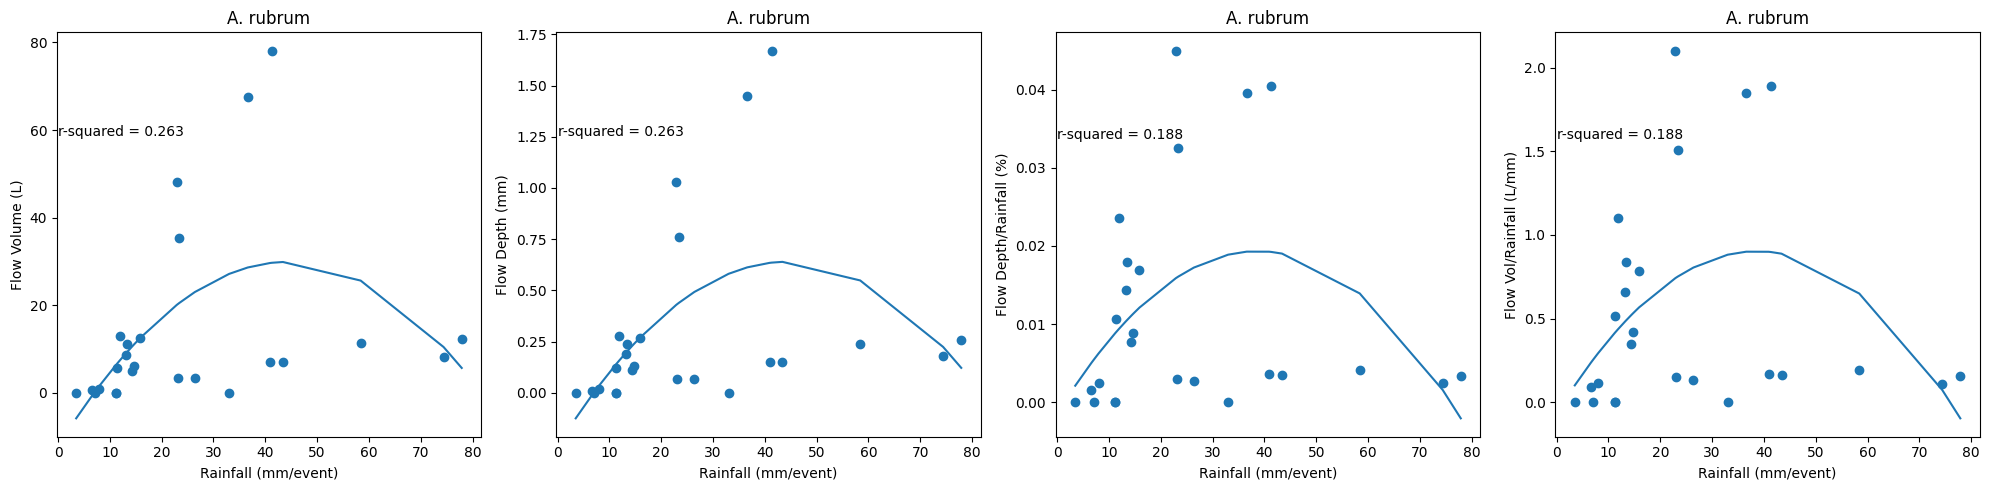

In [37]:
# Identification of saturation point 
# How to define:
#   - By volume of rain required before consistent stem flow is seen
#       - By comparison of stem flow vol/yield of each rain event together for each tree individually
#       - Similar to the above but with time on X, stem flow volume on Y for indv rain events 
#
# Viz wanted: 
#   - Volume/rain depth/stemflow yield by rain amount

# tree_list = set(dataframes['Mapping']['Species'])
# print(tree_list)


import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


if 1==1:
# for tree in tree_list:

    tree_name = 'A. rubrum'
    tree_metrics = dataframes['Mapping'].loc[[tree_name]]

    # Creating the plots we are about to populate with data
    fig, ax = plt.subplots(1,4, figsize=(20, 5))   
    
    #Populating one plot with data from the validation data set
    title = f'Stemflow Volume (L) by Rainfall Event - {tree_name}'
    ax[0].set_title(tree_name)
    ax[0].set_xlabel('Rainfall (mm/event)')
    ax[0].set_ylabel('Flow Volume (L)')
    x = rain_sorted_vol['Rain']
    y = rain_sorted_vol[tree_name]
    ax[0].scatter(x, y )

    #Calculating a line of best fit (and its r-squared) to add to the above referenced chart
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    y_predicted = p(x)
    rsq = round(r2_score(y, y_predicted),3)

    ax[0].annotate(f"r-squared = {rsq}",(0,np.max(y)*.75),)
    ax[0].plot(x, y_predicted )

    title = f'Stemflow Depth by Rainfall Event - {tree_name}'
    ax[1].set_title(tree_name)
    ax[1].set_xlabel('Rainfall (mm/event)')
    ax[1].set_ylabel('Flow Depth (mm)')
    x = rain_sorted_depth['Rain']
    y = rain_sorted_depth[tree_name]
    ax[1].scatter(x, y )
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    
    y_predicted = p(x)
    rsq = round(r2_score(y, y_predicted),3)

    ax[1].annotate(f"r-squared = {rsq}",(0,np.max(y)*.75),)
    ax[1].plot(x, y_predicted) 

    title = f'Stemflow Volume Yield by Rainfall Event - {tree_name}'
    ax[2].set_title(tree_name)
    ax[2].set_xlabel('Rainfall (mm/event)')
    ax[2].set_ylabel('Flow Depth/Rainfall (%)')
    x = rain_sorted_depth['Rain']
    y = rain_sorted_depth[tree_name]/rain_sorted_depth['Rain']
    ax[2].scatter(x, y )
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    
    y_predicted = p(x)
    rsq = round(r2_score(y, y_predicted),3)

    ax[2].annotate(f"r-squared = {rsq}",(0,np.max(y)*.75),)
    ax[2].plot(x, y_predicted )

    title = f'Stemflow Volume Yield by Rainfall Event - {tree_name}'
    ax[3].set_title(tree_name)
    ax[3].set_xlabel('Rainfall (mm/event)')
    ax[3].set_ylabel('Flow Vol/Rainfall (L/mm)')
    x = rain_sorted_vol['Rain']
    y = rain_sorted_vol[tree_name]/rain_sorted_vol['Rain']
    ax[3].scatter(x, y )
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    
    y_predicted = p(x)
    rsq = round(r2_score(y, y_predicted),3)

    ax[3].annotate(f"r-squared = {rsq}",(0,np.max(y)*.75),)
    ax[3].plot(x, y_predicted )

    plt.savefig('C:/Users/wisch/Documents/GitProjects/CanopyHydrodynamics/data/output/validation/A_Rubrum_vol_by_rain.png')

    plt.show()
    

Processing Z. serrata, Flow Volume (L)
logrithmic fit found. coeff =[  38.93964305  295.94417387 -300.42222069].
x [ 6.6  7.1  8.  11.2 11.3 11.9 13.2 13.4 14.3 14.7 15.9 22.9 23.1 23.4
 26.4 36.6 40.9 41.3 43.4 58.4 74.4]
y [  2.7   0.9   0.7  10.5   7.8  41.    5.   10.7  16.8  42.7  17.4  65.2
  13.9  48.2   8.7 126.6  16.1 156.1  19.6 118.5  45.3]
y_predicted [-5.36718096 -2.52360827  2.12371187 15.22582066 15.5719531  17.58652179
 21.62372283 22.20929241 24.74055729 25.81482247 28.87047917 43.07635413
 43.41496185 43.91741583 48.61462662 61.33559394 65.66108046 66.04005808
 67.97134526 79.53082941 88.9596766 ]
rsq = 0.368, args = ()
fff returning:
                  ~np.isnan(x) [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True] 
                    x [ 3.5  6.6  7.1  8.  11.2 11.2 11.3 11.9 13.2 13.4 14.3 14.7 15.9 22.9
 23.1 23.4 26.4 33.  36.6 40.9 41.3 43.4 58.4 74.4 77.9],
  

C:\Users\wisch\AppData\Local\Temp\ipykernel_20284\337146976.py:46: RuntimeWarning: invalid value encountered in log
  return a*np.log(b * x ) +c
C:\Users\wisch\AppData\Local\Temp\ipykernel_20284\337146976.py:46: RuntimeWarning: invalid value encountered in log
  return a*np.log(b * x ) +c
c:\Users\wisch\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\wisch\AppData\Local\Temp\ipykernel_20284\337146976.py:46: RuntimeWarning: invalid value encountered in log
  return a*np.log(b * x ) +c
C:\Users\wisch\AppData\Local\Temp\ipykernel_20284\337146976.py:46: RuntimeWarning: invalid value encountered in log
  return a*np.log(b * x ) +c
C:\Users\wisch\AppData\Local\Temp\ipykernel_20284\337146976.py:46: RuntimeWarning: invalid value encountered in log
  return a*np.log(b * x ) +c
C:\Users\wisch\AppData\Loc

logrithmic fit found. coeff =[  9.37971423   9.07662454 -32.65381309].
x [ 6.6  8.  11.3 11.9 13.2 13.4 14.3 14.7 15.9 22.9 23.1 23.4 26.4 36.6
 40.9 41.3 43.4 58.4 74.4 77.9]
y [ 0.6  0.9  5.8 13.1  8.7 11.2  5.   6.2 12.5 48.1  3.5 35.3  3.5 67.6
  7.  78.1  7.  11.3  8.3 12.2]
y_predicted [ 5.73521891  7.53961229 10.7790015  11.26426734 12.23674138 12.37779237
 12.9875191  13.24628625 13.98232758 17.4042143  17.48577755 17.6068078
 18.73826385 21.80246857 22.84438432 22.9356718  23.40087694 26.18530559
 28.45651008 28.88769565]
rsq = 0.092, args = ()
logrithmic fit found. coeff =[  9.37971423   9.07662454 -32.65381309].
x [ 6.6  8.  11.3 11.9 13.2 13.4 14.3 14.7 15.9 22.9 23.1 23.4 26.4 36.6
 40.9 41.3 43.4 58.4 74.4 77.9]
y [ 0.6  0.9  5.8 13.1  8.7 11.2  5.   6.2 12.5 48.1  3.5 35.3  3.5 67.6
  7.  78.1  7.  11.3  8.3 12.2]
y_predicted [ 5.73521891  7.53961229 10.7790015  11.26426734 12.23674138 12.37779237
 12.9875191  13.24628625 13.98232758 17.4042143  17.48577755 17.6068078
 1

C:\Users\wisch\AppData\Local\Temp\ipykernel_20284\337146976.py:46: RuntimeWarning: invalid value encountered in log
  return a*np.log(b * x ) +c
C:\Users\wisch\AppData\Local\Temp\ipykernel_20284\337146976.py:46: RuntimeWarning: invalid value encountered in log
  return a*np.log(b * x ) +c
C:\Users\wisch\AppData\Local\Temp\ipykernel_20284\337146976.py:46: RuntimeWarning: invalid value encountered in log
  return a*np.log(b * x ) +c
c:\Users\wisch\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\wisch\AppData\Local\Temp\ipykernel_20284\337146976.py:46: RuntimeWarning: invalid value encountered in log
  return a*np.log(b * x ) +c
C:\Users\wisch\AppData\Local\Temp\ipykernel_20284\337146976.py:46: RuntimeWarning: invalid value encountered in log
  return a*np.log(b * x ) +c
C:\Users\wisch\AppData\Loc

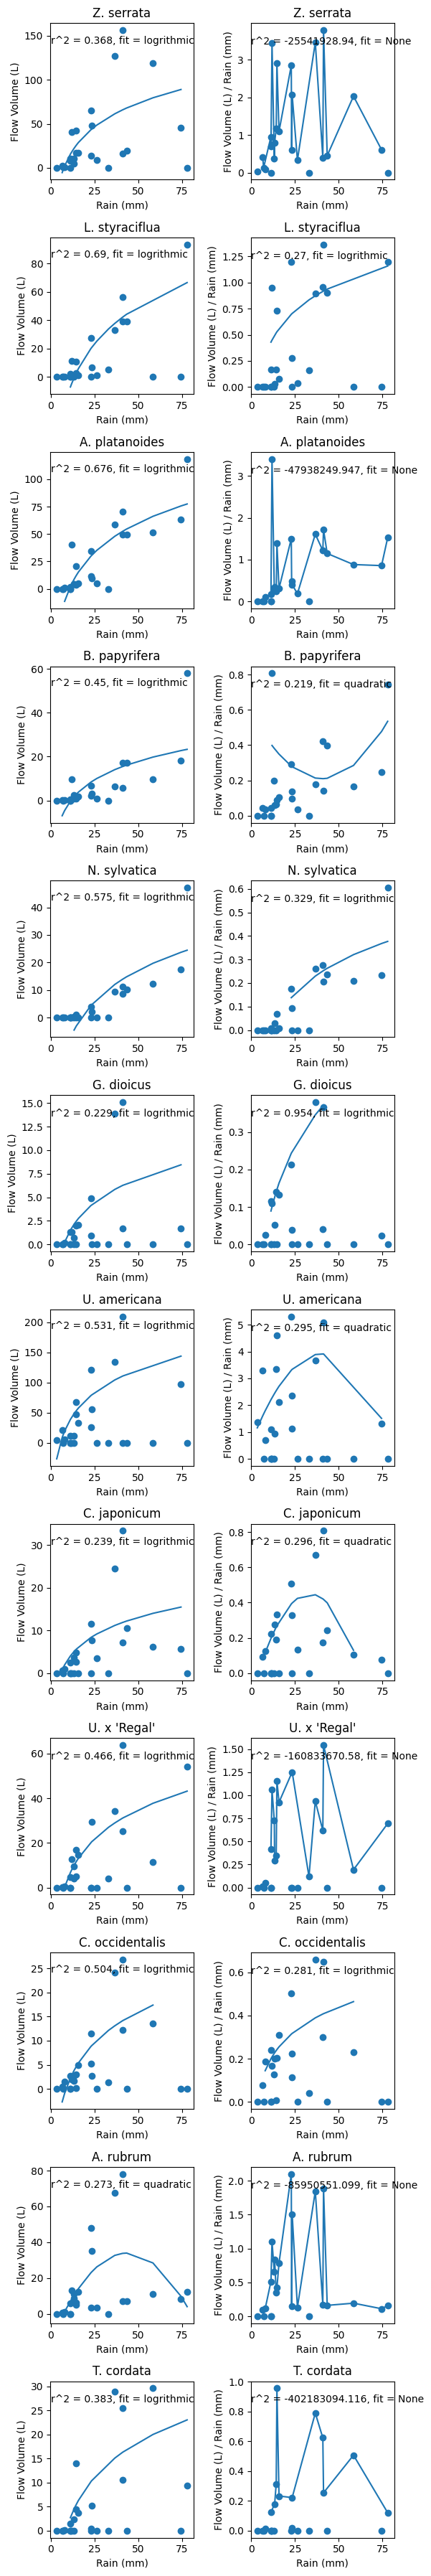

In [67]:
from typing import Callable
from IPython.core.debugger import Pdb

import matplotlib.pyplot as plt
import numpy as np
from numpy import array as arr, isnan
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


def gaussian(x, a, b, c):
    """
        Used for fitting data using an gaussian curve 
        Functions as an input to scipy curve_fit
    """
    y = a*np.exp(-1*b*x**2) + c
    return y

def exponential(x, a, b, c):
    """
        Used for fitting data using a general exponential curve 
        Functions as an input to scipy curve_fit
    """
    return a * np.exp(b*x) + c

def quadratic(x, a, b, c):
    """
        Used for fitting data using a general exponential curve 
        Functions as an input to scipy curve_fit
    """
    return a * x * x + b * x + c

def cubic(x, a, b, c ):
    """
        Used for fitting data using a general exponential curve 
        Functions as an input to scipy curve_fit
    """
    return x * x * x + a * x * x + b * x + c

def logrithmic(x, a, b, c):
    """
        Used for fitting data using a general exponential curve 
        Functions as an input to scipy curve_fit
    """

    return a*np.log(b * x ) +c

def try_fit_func(fit_func:Callable, x:arr, y:arr, *args):
    func_name = fit_func.__name__
    coeff = []
    try:
        coeff, pcov = curve_fit(fit_func, x, y, p0 = (1,1,2))#, *args)
    except RuntimeError :
        print(f'No {func_name} fit found. {len(coeff)}')

    if len(coeff) == 0:
        y_predicted, rsq = None, None
    else:
        print(f'{func_name} fit found. coeff ={coeff}.')
        y_predicted = fit_func(x, *coeff)
        print(f'x {x}')
        print(f'y {y}')
        print(f'y_predicted {y_predicted}')
        rsq = round(r2_score(y, y_predicted),3)
        print(f'rsq = {rsq}, args = {args}')
    return y_predicted, rsq, func_name, coeff 

def find_fit_func(fit_func,x:arr,y:arr):
    
    alt_fit_funcs = [logrithmic, quadratic, gaussian, cubic]
    # x_flitered = x[~np.isnan(x)]
    # y_filtered = y[~np.isnan(x)]
    x_flitered = x[x>0]
    y_filtered = y[x>0]
    x_flitered = x[y_filtered>.1]
    y_filtered = y[y_filtered>.1]
    # x_flitered = x
    # y_filtered = y

    y_predicted, rsq, fit_func_name, coeff = try_fit_func(fit_func, x_flitered, y_filtered)

    for alt_func in alt_fit_funcs:
        if len(coeff) != 0 and rsq>.2:
            print(f'''fff returning:
                  ~np.isnan(x) {~np.isnan(x)} 
                    x {x},
                    x_flitered {x_flitered},
                    y {y},
                    y_filtered {y_filtered}, 
                    y_predicted {y_predicted}''')
            return x_flitered, y_predicted, rsq, fit_func_name, coeff
        else:
            y_predicted, rsq, fit_func_name, coeff = try_fit_func(alt_func, x_flitered, y_filtered) 
    
    if len(coeff) == 0 or rsq<.2:
        fit_func_name = 'None'
        y_predicted = y_filtered
    
    print(f'fff returning: x_flitered {x_flitered}, y_predicted {y_predicted}')
    return x_flitered, y_predicted, rsq, fit_func_name, coeff

def add_plot(x, y, fit_func:Callable, plot, title ='',xlabel='Rainfall (mm/event)', ylabel=''):
    # Creating the plots we are about to populate with data  
    
    #Populating one plot with data from the validation data set
    title = f'{title}'
    plot.set_title(title)
    plot.set_xlabel(xlabel)
    plot.set_ylabel(ylabel)
    plot.scatter(x, y)
    #Calculating a line of best fit (and its r-squared) to add to the above referenced chart
    x_flitered, y_predicted, rsq, fit_type, coeff = find_fit_func(fit_func, arr(x), arr(y))

    plot.annotate(f"r^2 = {rsq}, fit = {fit_type}",(0,np.max(y)*.9),)
    plot.plot(x_flitered, y_predicted)
    return rsq, fit_type, coeff


def cross_plot(rows, cols, common_x, adj_denom = None, fit_func = quadratic):
    num_cols = len(cols)*2 if adj_denom else len(cols)
    num_rows = len(rows)
    plt.rcParams["figure.autolayout"] = True

    _, ax = plt.subplots(num_rows,num_cols, figsize = (3*num_cols,3*num_rows)) 
    fit_results = []
    for row_number, row_key in enumerate(rows):
        for col_number, col_metric in enumerate(cols):
            xlabel = common_x[0]
            ylabel = col_metric[0]
            title = f"{row_key}"
            
            print(f'Processing {row_key}, {ylabel}')

            rsq, fit_type, coeff = add_plot(
                    x[1], col_metric[1][row_key], fit_func, ax[row_number,col_number],
                        title, xlabel, ylabel)
            fit_results.append((rsq, fit_type, coeff ))
            if adj_denom:
                ylabel = f"{col_metric[0]} / {adj_denom[0]}"
                title = f"{row_key}"
                adj_col_num = col_number + len(cols)
                rsq, fit_type, coeff = add_plot(
                        x[1], col_metric[1][row_key]/adj_denom[1], fit_func,ax[row_number,adj_col_num],
                            title, xlabel, ylabel)
                fit_results.append((rsq, fit_type, coeff))
            

x=('Rain (mm)',rain_sorted_vol['Rain'])
tree_keyed_data_sets = [("Flow Volume (L)",rain_sorted_vol),]
                        # ("Flow Depth (mm)",rain_sorted_depth),]
labels = []
adjustment_denominator = x
#tree list 
keys = dataframes['Mapping'].index

# print(rain_sorted_vol)

# print(tree_keyed_data_sets[1][1]['T. cordata'])
# print(tree_keyed_data_sets[1][1]['T. cordata'][len(tree_keyed_data_sets[1][1]['T. cordata'])])
fit_result = cross_plot(rows= keys,cols=tree_keyed_data_sets, 
                        common_x =x, adj_denom = adjustment_denominator, fit_func = logrithmic )

# print(fit_result)
# plt.savefig('C:/Users/wisch/Documents/GitProjects/CanopyHydrodynamics/data/output/validation/munge_test_sort_nan_gr_3_mm_no_r_filter.png')
plt.show()
              

In [ ]:
# Stemflow Yeild = Total_rainfall_intercepted_by_canopy/stem flow volume 
# Total_rainfall_intercepted_by_canopy can be
#  Rain per sq meter mult by...
#       - Tot Hull Area, stem_hull_area, tot_psa, stem_psa, tot/stem surface area 


In [60]:
# adjustment_denominator = None

# rain = rain_sorted_vol['Rain']
# x=('Rain (mm)',rain_sorted_vol['Rain'])
# tree_keyed_data_sets = [("Flow Volume (L)",rain_sorted_vol),]
#                         # ("Flow Depth (mm)",rain_sorted_depth),]
# labels = []
# tree_list = dataframes['Mapping'].index

for tree in tree_list:
    rain_sorted_vol
print(rain_sorted_vol)
# print(rain_sorted_vol/dataframes['Mapping']['total_psa'])

# by_area_fit_result = cross_plot(rows= tree_list,cols=tree_keyed_data_sets, common_x =x, adj_denom = adjustment_denominator, fit_func = logrithmic )


            Rain  Z. serrata  L. styraciflua  A. platanoides  B. papyrifera  \
Date                                                                          
2020-05-08   0.2         0.0             0.0             0.0            0.0   
2020-09-09   0.2         0.0             0.1             0.0            0.0   
2020-04-10   0.3         0.0             0.0             0.0            0.0   
2020-08-17   0.4         0.0             0.0             0.0            0.0   
2020-01-10   0.5         0.0             0.0             0.0            0.0   
2020-02-08   1.1         0.0             0.0             0.0            0.0   
2020-09-29   1.2         0.0             0.0             0.1            0.0   
2020-07-28   1.4         0.0             0.0             0.0            0.0   
2022-10-15   2.2        25.3            15.7             0.0            3.5   
2020-01-08   2.6         0.0             0.0             0.0            0.0   
2020-05-09   3.5         0.1             0.0        